# Example Usage

It's very simple to use this pacakge. You can either import it directly into a python script with `from nbed import nbed`, or run the command `nbed` from the terminal.

## Importing
Here's an example where we've imported the package and pointed it at a `.xyz` file.

In [2]:
from nbed import nbed
import numpy as np
from nbed.driver import NbedDriver
from openfermion import count_qubits
from pathlib import Path
import json
from openfermion import get_sparse_operator, get_ground_state, QubitOperator

/Users/mac/Library/Caches/pypoetry/virtualenvs/nbed-V87YptuY-py3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/Users/mac/Library/Caches/pypoetry/virtualenvs/nbed-V87YptuY-py3.9/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
#Define all the variables of the molecule
geometry= str(Path('/Users/mac/Desktop/Master/Project/Nbed/tests/molecules/o2.xyz').absolute())
n_active_atoms= 1
basis= 'STO-3G'
xc_functional= 'b3lyp'
output= 'openfermion'
projector= 'huzinaga'
localization= 'spade'
convergence= 1e-10
transform= 'jordan_wigner'
name = 'O2_'

with open(geometry, 'r') as infile:
    xyz_string = infile.read()
print(xyz_string)

run_virtual_localization = False
run_fci_emb = False
run_ccsd_emb = True
run_dft_in_dft= False
max_ram_memory = 8_000

max_hf_cycles=5000

charge= 0
spin = 0

occupied_threshold = 0.99
virtual_threshold = 0.95

2

O   0.6160  0.0000  0.0000
O   -0.6160  0.0000  0.0000


In [7]:
#Run the NbedDriver class to get the energies and the nbed class to get the qubit hamiltonian
driver = NbedDriver(geometry = xyz_string,
                    n_active_atoms=n_active_atoms,
                    basis = basis,
                    charge = charge,
                    spin = spin,
                    xc_functional = xc_functional,
                    run_virtual_localization = run_virtual_localization,
                    run_fci_emb = run_fci_emb,
                    run_ccsd_emb = run_ccsd_emb,
                    run_dft_in_dft = run_dft_in_dft,
                    max_ram_memory = max_ram_memory,
                    max_hf_cycles=max_hf_cycles,
                    occupied_threshold=occupied_threshold,
                    projector = projector,
                    localization = localization,
                    return_dict = True,
                    unrestricted = True)

2 (2, 10, 10)
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
-0.005316706506940657


In [8]:
qham = nbed(
    geometry=xyz_string ,
    n_active_atoms=n_active_atoms,
    basis=basis,
    xc_functional=xc_functional,
    output=output,
    charge=charge,
    spin=spin,
    projector=projector,
    convergence=convergence,
    localization= localization,
    transform=transform,
    unrestricted = True,
    )

2 (2, 10, 10)
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
********************************************************************************
                         Summary of Embedded Calculation                        
********************************************************************************
global (cheap) DFT calculation -148.14749798700643
********************************************************************************
  Huzinaga calculation
Total energy - active system at RHF level: -147.99796391577206
length of huzinaga embedded fermionic Hamiltonian: 416
number of qubits required: 10
********************************************************************************
                         Summary of reference Calculation                       
********************************************************************************


## Classical results

In [14]:
distances = np.arange(0.25001, 1.3, 0.020)
atomic_distances = [np.sqrt(2 *i**2) for i in distances]
charge = 0 
spin = 0

for method in ['restricted']:
    for projector in ['huzinaga', 'mu']:

        if method == 'restricted':
            meth= False
        if method == 'unrestricted':
            meth= True

        hf_energies = []
        ccsd_energies = []
        emb_hf_energies = []
        emb_ccsd_energies = []
        fci_energies = []
        classical_energies = []
        dft_in_dft = []
        emb_dft = []
        
        exact_energies = []
        vqe_energies = []

        for dist in distances:
            new_geometry = xyz_string.replace("0.6160", str(dist))

            driver = NbedDriver(geometry = new_geometry,
                            n_active_atoms=1,
                            basis = basis,
                            charge = charge,
                            spin = spin,
                            xc_functional = xc_functional,
                            run_virtual_localization = run_virtual_localization,
                            run_fci_emb = False,
                            run_ccsd_emb = True,
                            run_dft_in_dft = True,
                            max_ram_memory = max_ram_memory,
                            max_hf_cycles=max_hf_cycles,
                            occupied_threshold=occupied_threshold,
                            projector = projector,
                            localization = localization,
                            return_dict = True,
                            unrestricted= meth,
                            )
            
            qham = nbed(
                geometry= new_geometry,
                n_active_atoms=1,
                basis=basis,
                xc_functional=xc_functional,
                output=output,
                charge=charge,
                spin=spin, 
                projector=projector,
                convergence=convergence,
                localization= localization,
                transform=transform,
                unrestricted= meth,
                )

            emb_hf_energies.append(driver.molecule_info['hf_emb'])
            emb_ccsd_energies.append(driver.molecule_info['ccsd_emb'])
            ccsd_energies.append(driver.molecule_info['e_ccsd'])
            hf_energies.append(driver.molecule_info['e_rhf'])
            fci_energies.append(driver.molecule_info['FCI energy'])
            classical_energies.append(driver.molecule_info['classical_energy'])
            dft_in_dft.append(driver.molecule_info['e_dft_in_dft'])
            emb_dft.append(driver.molecule_info['emb_dft'])

            qubitOp = HamiltonianConverter(qham).qiskit
            var_form = ExcitationPreserving(num_qubits = qubitOp.num_qubits, 
                                        reps = 1, 
                                        initial_state = init_state)
            vqe = VQE(ansatz = Ansatz_1, 
                optimizer = L_BFGS_B(maxiter = 200),  
                quantum_instance = qi,
                callback= callback)

            vqe_result = vqe.compute_minimum_eigenvalue(qubitOp).eigenvalue
            vqe_energies.append(vqe_result)

            solver = NumPyMinimumEigensolver()
            result = solver.compute_minimum_eigenvalue(operator = qubitOp)
            exact_energies.append(result.eigenvalue)

            print(new_geometry)
            print('ccsd', driver.molecule_info['e_ccsd'])
            print('hf', driver.molecule_info['e_rhf'])
            print('exact',result.eigenvalue +driver.molecule_info['classical_energy'])
            print('vqe', vqe_result+driver.molecule_info['classical_energy'])
            print('fci', driver.molecule_info['FCI energy'])

        vqe = [i.real for i in vqe_energies]
        exact = [i.real for i in exact_energies]

        energies = {}
        energies['distances'] = atomic_distances
        energies['e_hf'] = emb_hf_energies
        energies['e_ccsd'] = emb_ccsd_energies
        energies['ccsd'] = ccsd_energies
        energies['hf'] = hf_energies
        energies['global_fci'] = fci_energies
        energies['classical_energies'] = classical_energies
        energies['dft_in_dft'] = dft_in_dft
        energies['emb_dft'] = emb_dft

        energies['vqe_emb'] = vqe 
        energies['exact_emb'] = exact
        energies['vqe_energy'] = vqe + classical_energies
        energies['exact_energy'] = exact + classical_energies
        
        energies['vqe_exact'] = error_calculation(np.array(vqe), np.array(exact))
        energies['vqe_ccsd'] = error_calculation(np.array(vqe), np.array(energies['e_ccsd']))
        energies['exact_ccsd'] = error_calculation(np.array(exact_energies), np.array(energies['e_ccsd']))

        energies['eccsd_fci'] = error_calculation(np.array(energies['ccsd']), np.array(energies['global_fci']))
        energies['ehf_fci'] = error_calculation(np.array(energies['hf']), np.array(energies['global_fci']))
        energies['dft_fci'] = error_calculation(np.array(energies['dft_in_dft']), np.array(energies['global_fci']))
        energies['vqe_fci'] = error_calculation(np.array(vqe), np.array(energies['global_fci']))
        energies['exact_fci'] = error_calculation(np.array(exact), np.array(energies['global_fci']))
        #save as a JSON file
        with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/' + name + '_' + str(projector) +'_'+ method+'2.json', 'w') as fp:
            json.dump(energies, fp)
            
print("All energies have been calculated")

-0.0009804794862905573
********************************************************************************
                         Summary of Embedded Calculation                        
********************************************************************************
global (cheap) DFT calculation -131.3520679562346
********************************************************************************
  Huzinaga calculation
Total energy - active system at RHF level: -131.01698932218036
length of huzinaga embedded fermionic Hamiltonian: 432
number of qubits required: 10
********************************************************************************
                         Summary of reference Calculation                       
********************************************************************************
2

O   0.2001  0.0000  0.0000
O   -0.2001  0.0000  0.0000
ccsd -127.6834033726761
hf -131.0169893241034
exact -128.3718737949956
vqe (-128.09528174650447+0j)
fci -130.88198112315175
-0.0153

In [4]:
distances = np.arange(0.25001, 1.3, 0.020)
atomic_distances = [np.sqrt(2 *i**2) for i in distances]
charge = 0 
spin = 0

for method in ['restricted']:
    for projector in ['huzinaga']:

        if method == 'restricted':
            meth= False
        if method == 'unrestricted':
            meth= True

        hf_energies = []
        ccsd_energies = []
        emb_hf_energies = []
        emb_ccsd_energies = []
        fci_energies = []
        classical_energies = []
        dft_in_dft = []
        emb_dft = []
        
        exact_energies = []
        vqe_energies = []

        for dist in distances:
            new_geometry = xyz_string.replace("0.6160", str(dist))

            driver = NbedDriver(geometry = new_geometry,
                            n_active_atoms=1,
                            basis = basis,
                            charge = charge,
                            spin = spin,
                            xc_functional = xc_functional,
                            run_virtual_localization = run_virtual_localization,
                            run_fci_emb = False,
                            run_ccsd_emb = True,
                            run_dft_in_dft = True,
                            max_ram_memory = max_ram_memory,
                            max_hf_cycles=max_hf_cycles,
                            occupied_threshold=occupied_threshold,
                            projector = projector,
                            localization = localization,
                            return_dict = True,
                            unrestricted= meth,
                            )
            

            emb_hf_energies.append(driver.molecule_info['hf_emb'])
            emb_ccsd_energies.append(driver.molecule_info['ccsd_emb'])
            ccsd_energies.append(driver.molecule_info['e_ccsd'])
            hf_energies.append(driver.molecule_info['e_rhf'])
            fci_energies.append(driver.molecule_info['FCI energy'])
            classical_energies.append(driver.molecule_info['classical_energy'])
            dft_in_dft.append(driver.molecule_info['e_dft_in_dft'])
            emb_dft.append(driver.molecule_info['emb_dft'])

        energies = {}
        energies['distances'] = atomic_distances
        energies['e_hf'] = emb_hf_energies
        energies['e_ccsd'] = emb_ccsd_energies
        energies['ccsd'] = ccsd_energies
        energies['hf'] = hf_energies
        energies['global_fci'] = fci_energies
        energies['classical_energies'] = classical_energies
        energies['dft_in_dft'] = dft_in_dft
        energies['emb_dft'] = emb_dft


        energies['eccsd_fci'] = error_calculation(np.array(energies['ccsd']), np.array(energies['global_fci']))
        energies['ehf_fci'] = error_calculation(np.array(energies['hf']), np.array(energies['global_fci']))
        energies['dft_fci'] = error_calculation(np.array(energies['dft_in_dft']), np.array(energies['global_fci']))

2 (10, 10)
-0.10945701218758601
2 (10, 10)
2 (10, 10)
-0.0009069319172719559
2 (10, 10)
2 (10, 10)
-0.0011553858506473298
2 (10, 10)
2 (10, 10)
-0.0029355337250025863
2 (10, 10)
2 (10, 10)
-0.0031371816286341957
2 (10, 10)
2 (10, 10)
-0.011749811548071722
2 (10, 10)
2 (10, 10)
-0.0035037074718273433
2 (10, 10)
2 (10, 10)
-0.003693935143120373
2 (10, 10)
2 (10, 10)
-0.0038238401156932755
2 (10, 10)
2 (10, 10)
-0.02040261393442012
2 (10, 10)
2 (10, 10)
-0.004114468398533962
2 (10, 10)
2 (10, 10)
-0.011828489735925155
2 (10, 10)
2 (10, 10)
-0.006924835735231522
2 (10, 10)
2 (10, 10)
-0.004508964759677312
2 (10, 10)
2 (10, 10)
-0.008418084112507948
2 (10, 10)
2 (10, 10)
-0.0048662725817677725
2 (10, 10)
2 (10, 10)
-0.006887359808442884
2 (10, 10)
2 (10, 10)
-0.00505277008543679
2 (10, 10)
2 (10, 10)
-0.003802937883986831
2 (10, 10)
2 (10, 10)
-0.005473433915866842
2 (10, 10)
2 (10, 10)
-0.005747188043946263
2 (10, 10)
2 (10, 10)
-0.00603890646351702
2 (10, 10)
2 (10, 10)
-0.006348587989045

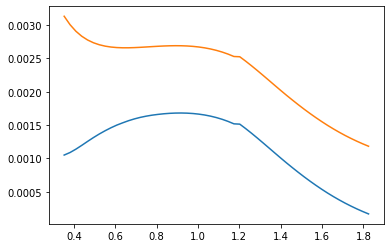

In [9]:
#plt.plot(energies['distances'], energies['eccsd_fci'])
plt.plot(energies['distances'], energies['ehf_fci'])
plt.plot(energies['distances'], energies['dft_fci'])

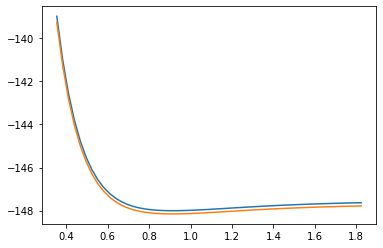

In [10]:
plt.plot(energies['distances'], energies['hf'])
#plt.plot(energies['distances'], energies['ccsd'])
plt.plot(energies['distances'], energies['dft_in_dft'])

In [6]:
import pennylane as qml
from pennylane import qchem
from pennylane.templates import UCCSD, ParticleConservingU2
from functools import partial
from qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigen_solvers.minimum_eigen_solver import MinimumEigensolver, MinimumEigensolverResult
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQE
import matplotlib.pyplot as plt
import numpy as np
from qiskit.opflow import PauliSumOp
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow.state_fns.circuit_state_fn import CircuitStateFn
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.circuit.library.n_local import ExcitationPreserving, EfficientSU2
from qiskit.algorithms.optimizers.cobyla import COBYLA
from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder
from nbed.ham_converter import HamiltonianConverter

In [6]:
qubitOp = HamiltonianConverter(qham).qiskit
qubitOp_sparse = qubitOp.to_spmatrix()
qubitOp.num_qubits

10

In [41]:
solver = NumPyMinimumEigensolver()
exact = solver.compute_minimum_eigenvalue(operator = qubitOp)
exact.eigenvalue 

-61.9561580611191

In [8]:
from scipy.sparse import csr_matrix
num_orbitals = qubitOp.num_qubits
num_electrons = 6
hartree_fock_state = np.append(np.ones(num_electrons), np.zeros(num_orbitals-num_electrons)).astype(int)
hartree_fock_string = "".join([str(i) for i in hartree_fock_state])
hartree_fock_int = int(hartree_fock_string, 2)
sparse_hf = csr_matrix(np.eye(1, 2**num_orbitals, hartree_fock_int))
(sparse_hf @ qubitOp_sparse @ sparse_hf.H)[0,0]

(-61.94900198373582+0j)

In [9]:
#construct quantum citcuit from hartree
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
num_orbitals = 10
num_electrons = 6
circuit = QuantumCircuit(num_orbitals)
for i in range(num_electrons):
    circuit.x(i)
init_state = circuit
init_state.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     ├───┤
q_4: ┤ X ├
     ├───┤
q_5: ┤ X ├
     └───┘
q_6: ─────
          
q_7: ─────
          
q_8: ─────
          
q_9: ─────

In [10]:
values = []
params = []
def callback(step, param, value, var):
    values.append(value)
    params.append(param)

In [11]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.providers.basicaer.statevector_simulator import StatevectorSimulatorPy

backend = StatevectorSimulatorPy()
qi = QuantumInstance(backend, shots = 2**8)

In [13]:
Hamiltonian = qubitOp.from_list([('II', 1), ('ZZ', 2),('YY', 3),('ZZ', 4)])
Ansatz_1 = ExcitationPreserving(num_qubits = num_orbitals, 
                                reps = 1, 
                                initial_state = init_state)
Ansatz_2 = EfficientSU2(num_qubits= num_orbitals,
                        reps = 1,
                        initial_state = init_state)

In [28]:
data = {
    'hamiltonian': qubitOp,
    'Ansatz_1': Ansatz_1,
    'Ansatz_2': Ansatz_2
}
with open('simulation_data.json', 'w') as outfile:
    json.dump(data, outfile, cls=RuntimeEncoder)


In [65]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
converter = QubitConverter(JordanWignerMapper())
var_form = UCCSD(qubit_converter= converter,
                num_particles= [3,3],
                num_spin_orbitals= num_orbitals,
                reps = 1,
                initial_state = init_state)
ansatz2.decompose().depth()

34

In [45]:
vqe_values = {}
for ansatz in [Ansatz_1, Ansatz_2]:
    values = []
    params = []
    vqe = VQE(ansatz = ansatz, 
        optimizer = L_BFGS_B(maxiter = 200),  
        quantum_instance = qi,
        callback= callback)
    vqe_values[str(ansatz)] = values
    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp).eigenvalue

In [52]:
len(vqe_values[str(Ansatz_1)])

1056

ValueError: operands could not be broadcast together with shapes (1025,) (1056,) 

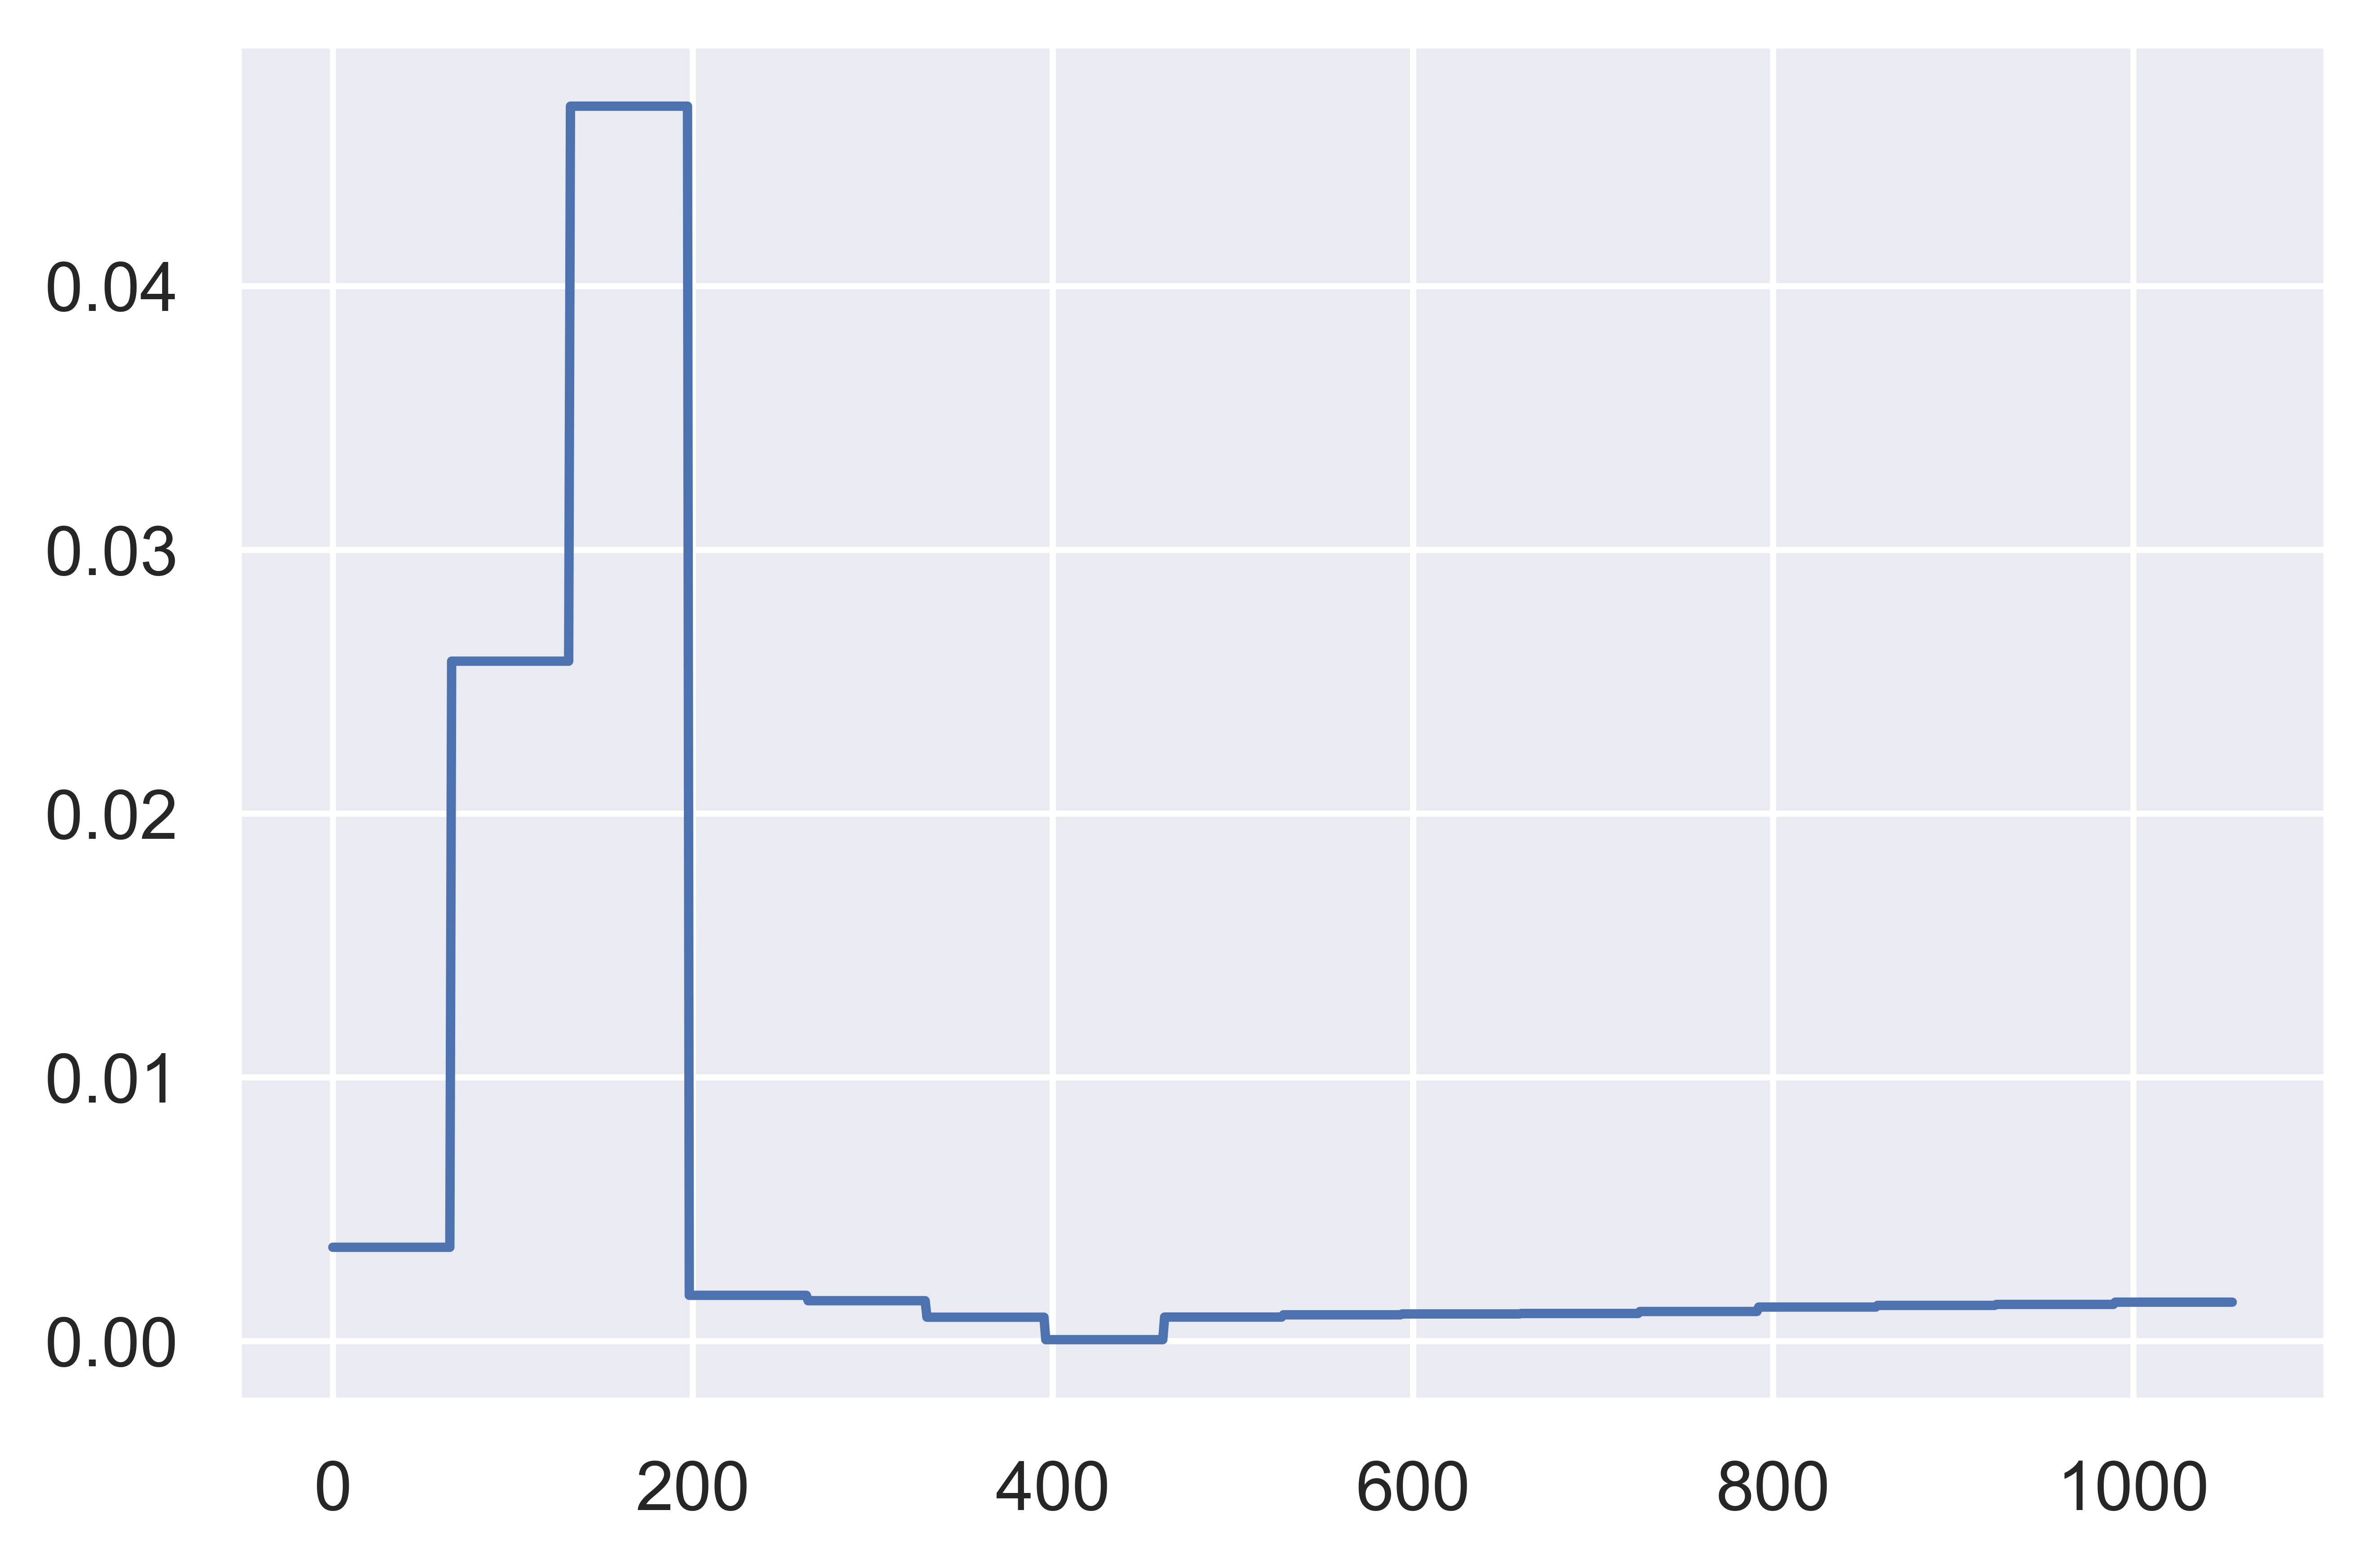

In [57]:
import seaborn as sns
sns.set()
plt.plot(error_calculation([x+ driver.classical_energy for x in vqe_values[str(Ansatz_1)]], np.full(len(vqe_values[str(Ansatz_1)]), driver.molecule_info['FCI energy'])), label = 'ExcitationPreserving on a noisless simulator')
plt.plot(error_calculation([x+ driver.classical_energy for x in vqe_values[str(Ansatz_2)]], np.full(len(vqe_values[str(Ansatz_1)]),driver.molecule_info['FCI energy'])), label = 'EfficientSU2 on a noisless simulator')
plt.axhline(exact.eigenvalue +driver.classical_energy, color = 'r', linestyle = '--', label = 'Exact diagonalisation energy')
plt.ylabel('Energy [Ha]')
plt.xlabel('Count')

plt.rcParams["figure.dpi"] = 1000
plt.title('VQE energy convergence on a noisless simulator')

# Put a legend below current axis
plt.legend()
plt.show()

In [75]:
def plot_vqe_results( interim_values, ref_energy, 
    plot_gradients=True, log_scale=False):
    """
    """
    fig, axis = plt.subplots()
    
    # measurement-error-mitiagtion + zero-noise-extrapolation data
    X_mem_zne,Y_mem_zne = zip(*interim_values['energy_mem_zne'])
    X_mem_zne,Y_mem_zne= np.array(X_mem_zne), np.array(Y_mem_zne)
    # raw + zero-noise-extrapolation data
    X_raw_zne,Y_raw_zne = zip(*interim_values['energy_raw_zne'])
    X_raw_zne,Y_raw_zne= np.array(X_raw_zne), np.array(Y_raw_zne)
    # measurement-error-mitiagtion data
    X_mem,Y_mem = zip(*interim_values['energy_mem'])
    X_mem,Y_mem= np.array(X_mem), np.array(Y_mem)
    # raw data
    X_raw,Y_raw = zip(*interim_values['energy_raw'])
    X_raw,Y_raw = np.array(X_raw), np.array(Y_raw)
    
    # Plot chemically accurate region:
    axis.fill_between(X_raw, 0, 0.0016, alpha=0.3, color='green', label='Chemical accuracy', hatch=r"//")
    
    # plot error curves:
    Y_error_raw = abs(Y_raw - ref_energy)
    axis.plot(X_raw, Y_error_raw, color='cyan', label='RAW optimizer output', marker='o', ls='--')
    Y_error_mem = abs(Y_mem - ref_energy)
    axis.plot(X_mem, Y_error_mem, color='blue', label='MEM optimizer output', marker='x', ls='--')
    Y_error_raw_zne = abs(Y_raw_zne - ref_energy)
    axis.plot(X_raw_zne, Y_error_raw_zne, color='purple', label='RAW+ZNE optimizer output', marker='x', ls='--')
    Y_error_mem_zne = abs(Y_mem_zne - ref_energy)
    axis.plot(X_mem_zne, Y_error_mem_zne, color='pink', label='MEM+ZNE optimizer output', marker='x', ls='--')
    
    if plot_gradients:
        axis_param = axis.twinx()
        X_grad, Y_grads = zip(*interim_values['gradients'])
        for Y_g in zip(*Y_grads):
            axis_param.plot(X_grad, Y_g, alpha=0.5)
        axis_param.set_ylabel('Parameter gradients $ \\partial E(\\theta) / \\partial \\theta_i $')
    if log_scale:
        axis.set_yscale('log')

    axis.set_xlabel('nfev')
    axis.set_ylabel('Energy error [Ha]')
    axis.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=3)
    return fig

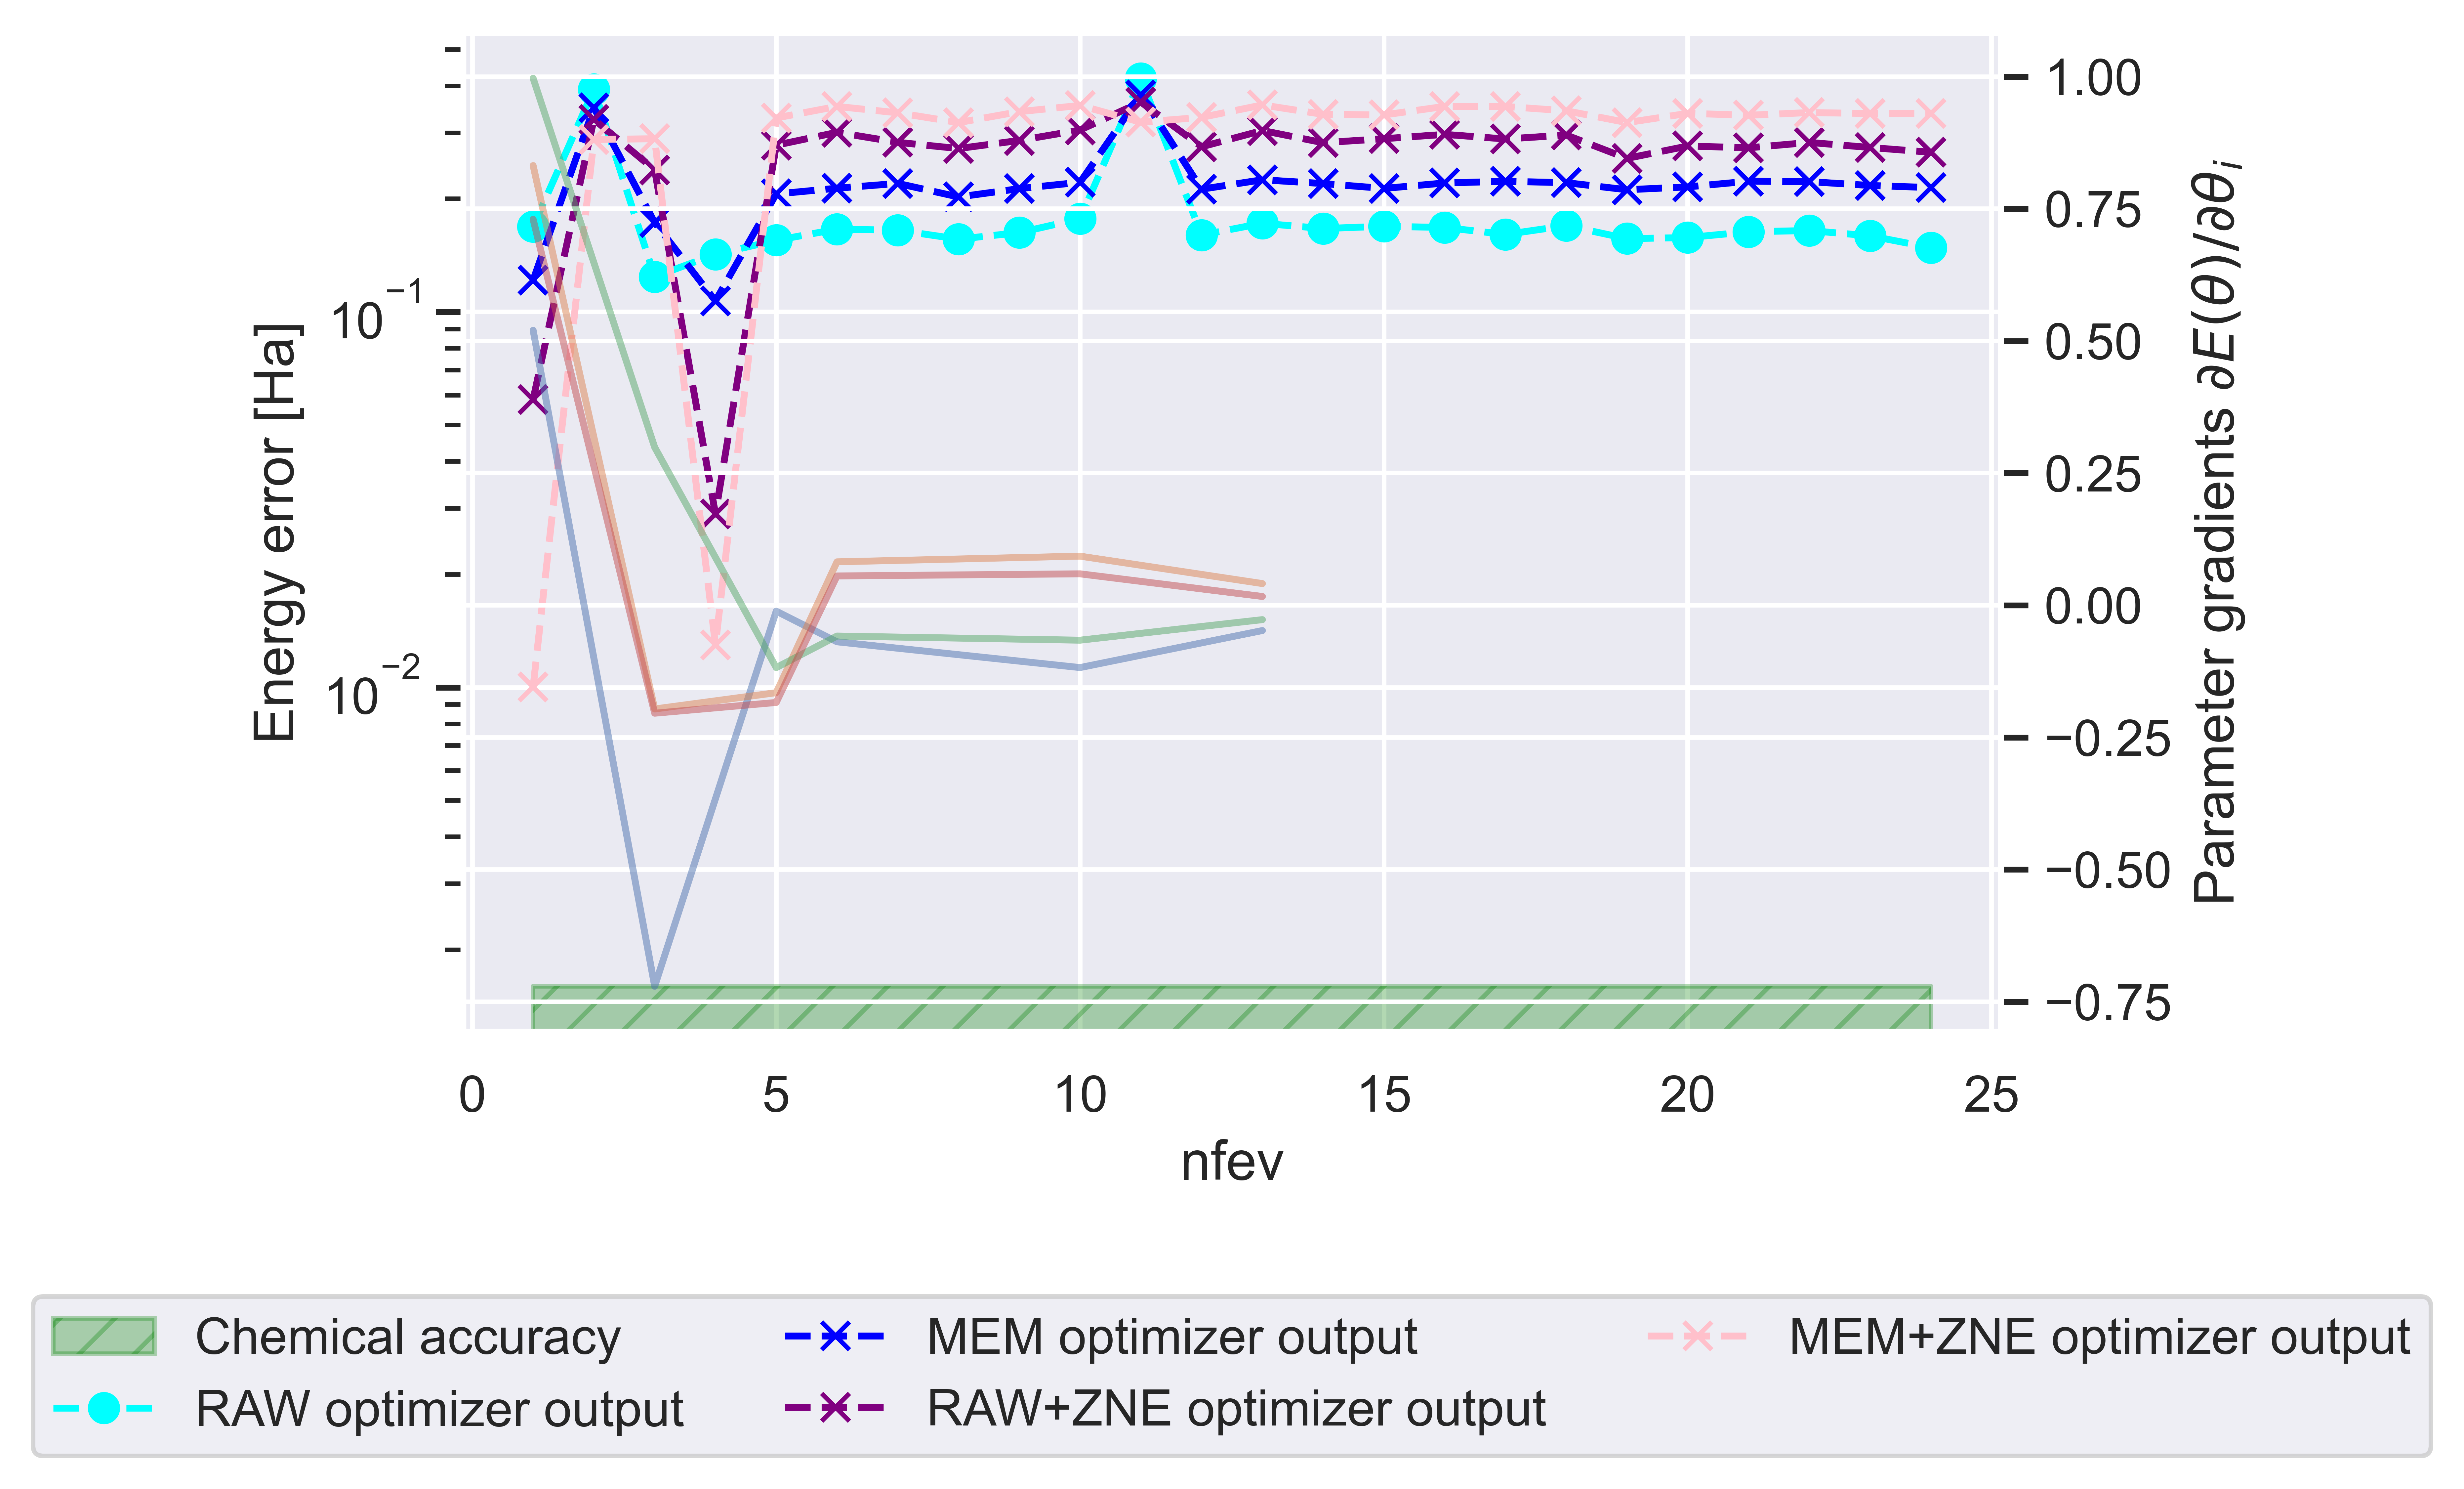

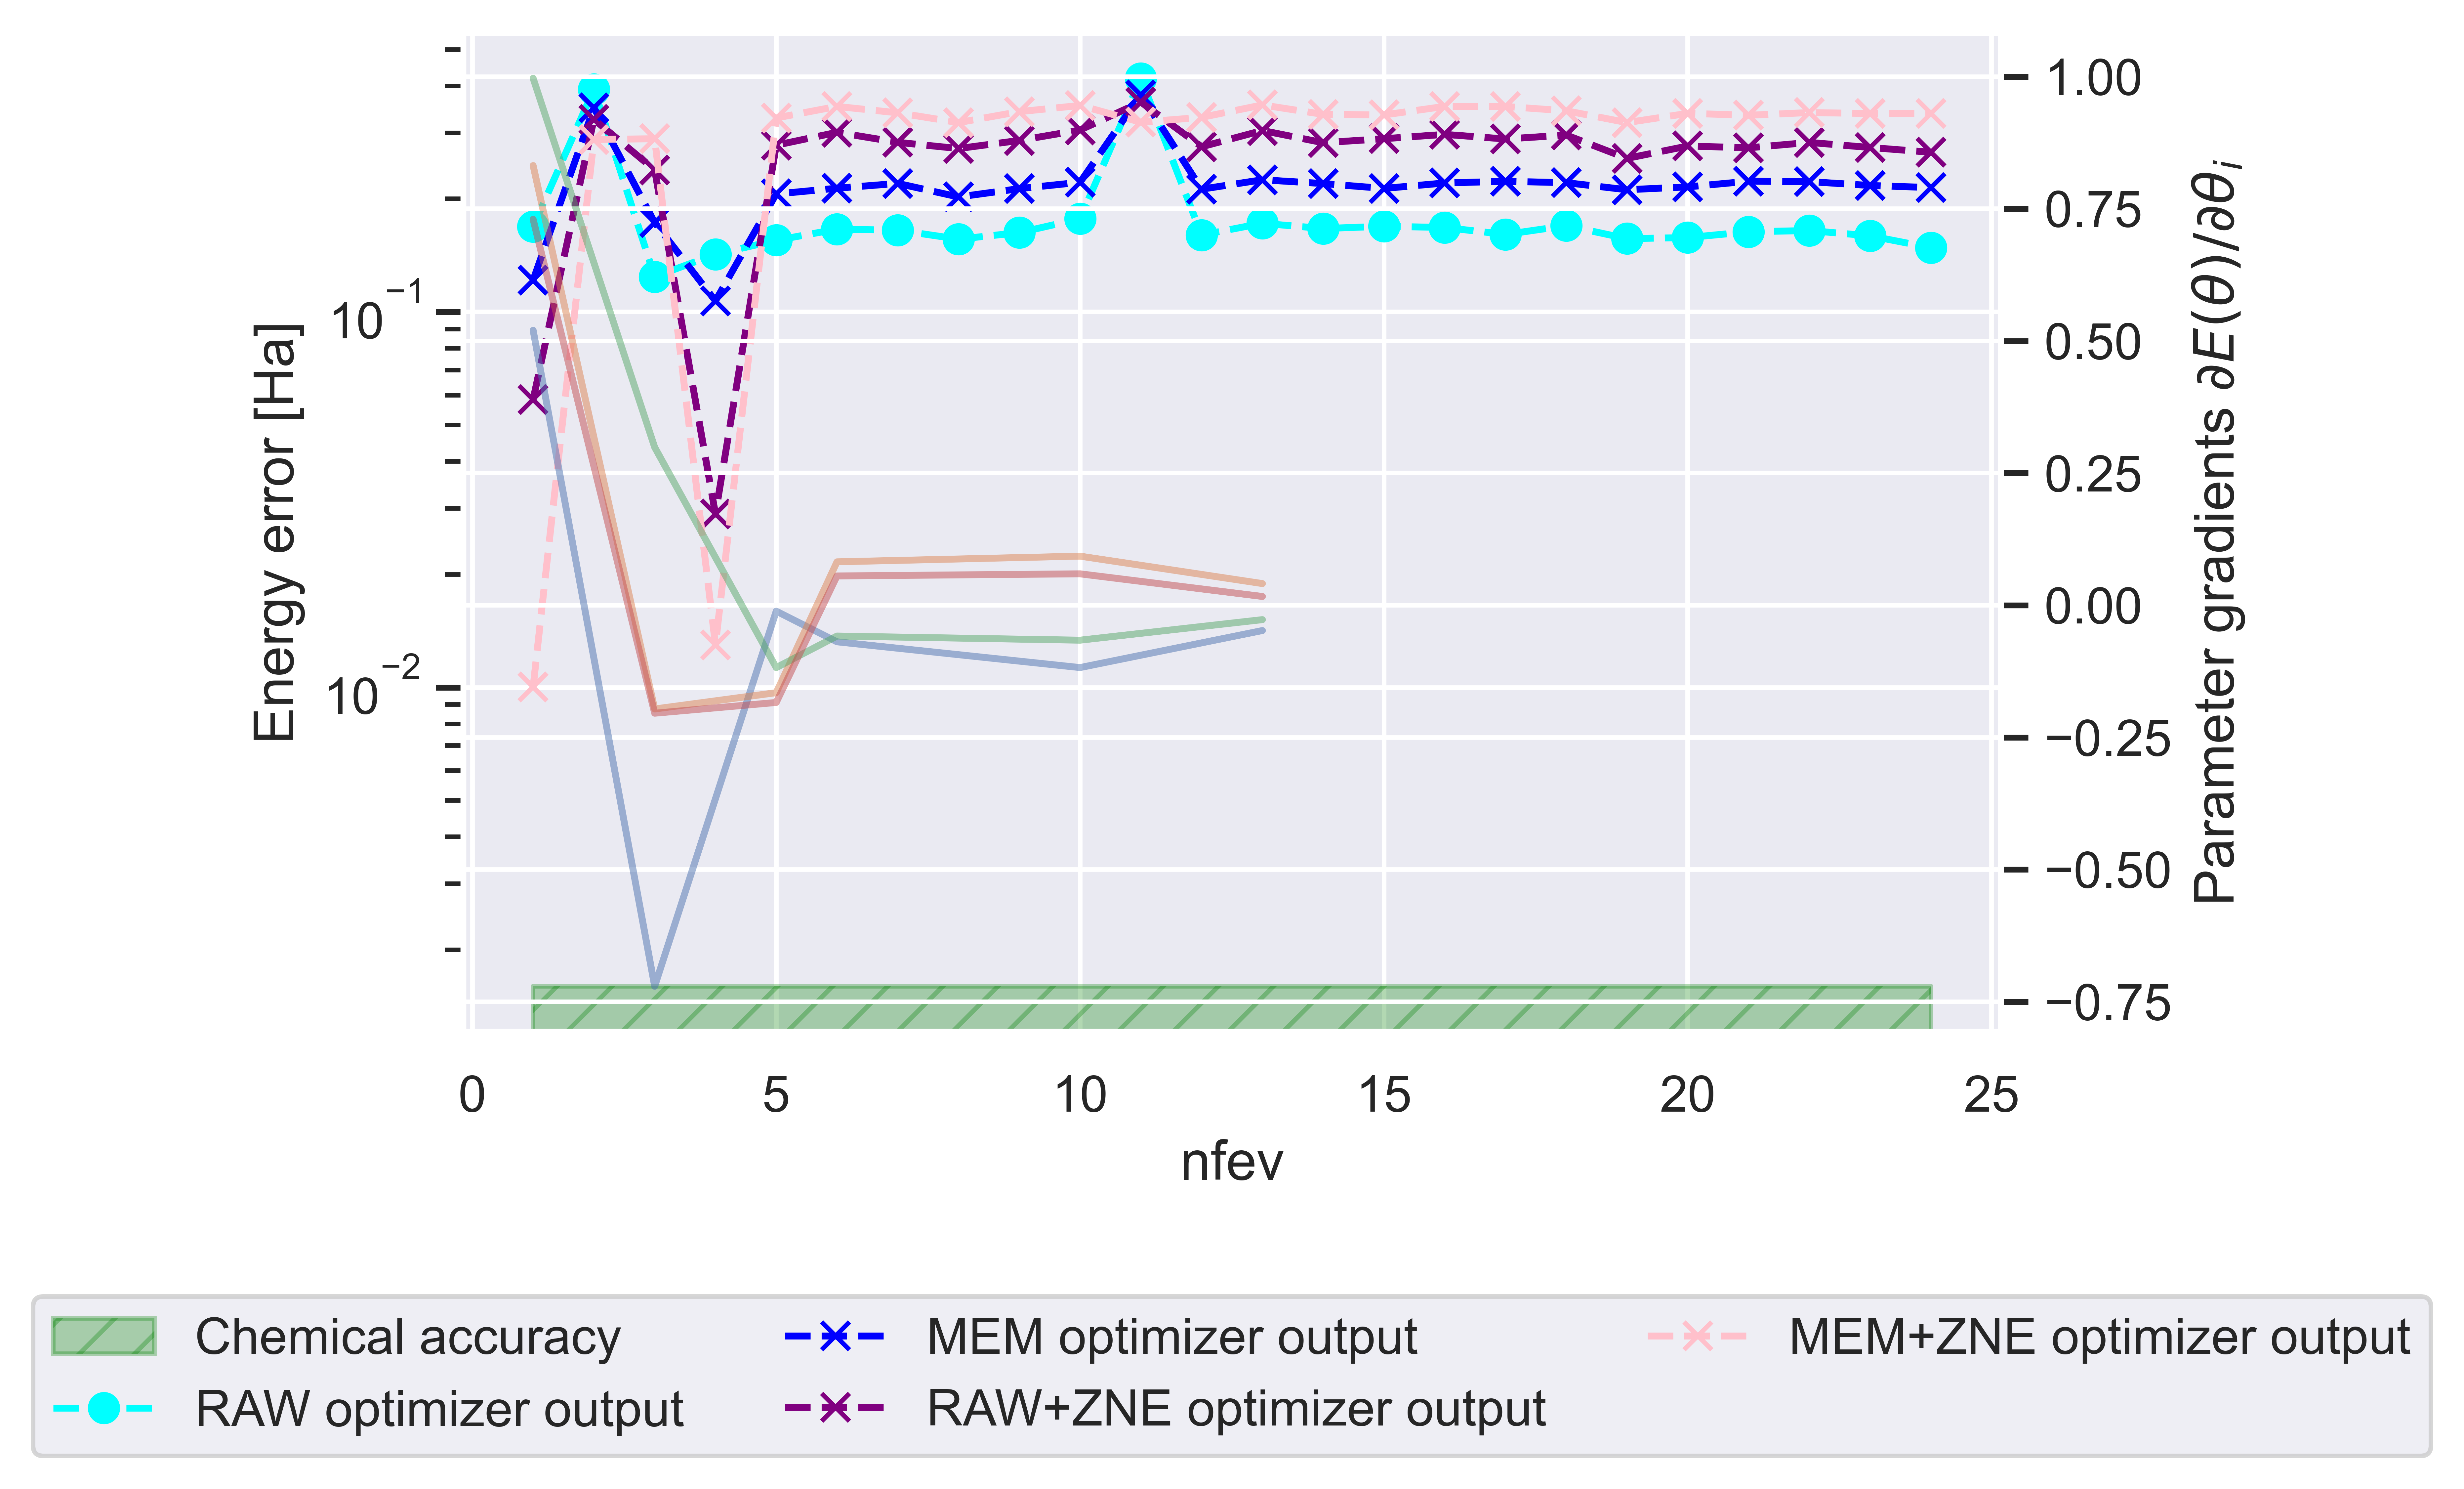

In [82]:
with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibm_cairo_simulation.json') as f:
   cairo = json.load(f)

with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibm_geneva_simulation.json') as f:
   geneva = json.load(f)

with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibm_lagos_simulation.json') as f:
   lagos = json.load(f)

with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibmq_jakarta_simulation.json') as f:
   jakarta = json.load(f)
   
qpu = lagos
for energy in ['energy_mem_zne', 'energy_raw_zne', 'energy_mem', 'energy_raw']:
    qpu['interim_data'][energy] = [ [i, val + driver.molecule_info['classical_energy']] for i, val in qpu['interim_data'][energy]]
vqe_result = qpu['interim_data']['energy_raw']
interim_values = qpu['interim_data']
plot_vqe_results(interim_values, driver.molecule_info['FCI energy'], log_scale= True)

In [77]:
with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibm_cairo_simulation.json') as f:
   cairo = json.load(f)

with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibm_geneva_simulation.json') as f:
   geneva = json.load(f)

with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibm_lagos_simulation.json') as f:
   lagos = json.load(f)

with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/ibmq_jakarta_simulation.json') as f:
   jakarta = json.load(f)

In [34]:
cairo.keys()
cairo['interim_data'].keys()
cairo['interim_data']['energy_raw']
energy_raw = [val for i, val in cairo['interim_data']['energy_raw']]

[-61.53893548519876,
 -61.38698996948756,
 -61.82571520151588,
 -61.556839551077104,
 -61.862474565356216,
 -61.86728332014425,
 -61.87336180302588,
 -61.861125995637614,
 -61.870900664656496,
 -61.86841881259443,
 -61.77861632743802,
 -57.841393828741246,
 -61.727201308803444,
 -61.86680700615022,
 -61.86924564740616,
 -61.87270936380916,
 -61.865781296739954,
 -61.85926302219294,
 -61.86257696675387,
 -61.86511143622554,
 -61.862652209826145]

In [ ]:
sns.set()
plt.plot(vqe_values[str(Ansatz_1)], label = 'ExcitationPreserving on a noisless simulator')
plt.plot(vqe_values[str(Ansatz_2)], label = 'EfficientSU2 on a noisless simulator')
plt.ylabel('Energy [Ha]')
plt.xlabel('Iterations')

plt.rcParams["figure.dpi"] = 1000
plt.title('VQE energy convergence')

# Put a legend below current axis
plt.legend()
plt.show()

In [ ]:
distances = np.arange(0.2001, 1.3, 0.0150)
exact_energies = []
vqe_energies = []
values = []
params = []

charge = 1
spin = 1

for dist in distances:
    new_geometry = xyz_string.replace("0.6160", str(dist))
    print(new_geometry)

    qham = nbed(
    geometry= new_geometry,
    n_active_atoms=1,
    basis=basis,
    xc_functional=xc_functional,
    output=output,
    charge=charge,
    spin=spin, 
    projector=projector,
    convergence=convergence,
    localization= localization,
    transform=transform,
    )

    qubitOp = HamiltonianConverter(qham).qiskit

    var_form = ExcitationPreserving(num_qubits = num_orbitals, 
                                reps = 1, 
                                initial_state = init_state)
    
    vqe = VQE(ansatz = var_form, 
        optimizer = COBYLA(maxiter = 400),  
        quantum_instance = qi,
        callback= callback)

    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp).eigenvalue
    vqe_energies.append(vqe_result)

    solver = NumPyMinimumEigensolver()
    result = solver.compute_minimum_eigenvalue(operator = qubitOp)
    exact_energies.append(result.eigenvalue)
    print("Interatomic Distance:", "VQE Result:", vqe_result, "Exact", result.eigenvalue)
    
print("All energies have been calculated")

In [ ]:
vqe = [i.real for i in vqe_energies]
with open('/Users/mac/Desktop/Master/Project/Nbed/tests/hamiltonians/' + name +'_spin'+ str(spin) +'_'+str(projector) + '.json', 'r+') as f:
    data['vqe_energy'] = vqe
    data['exact_energy'] = exact_energies
    data['vqe_exact'] = error_calculation(np.array(vqe), np.array(exact_energies))
    data['vqe_fci'] = error_calculation(np.array(vqe), np.array(data['huzinaga_fci']))
    data['exact_fci'] = error_calculation(np.array(vqe), np.array(data['huzinaga_fci']))
    json.dump(data, f)

In [1]:
def error_calculation(calc, correct):
    error = np.abs(calc - correct)
    percentage = error/np.abs(correct)
    return percentage.tolist()

def calculate_stats(array):
    max = np.max(array)
    min = np.min(array)
    average = np.mean(array)
    return max, min, average

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=8192, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

### Openfermion

In [ ]:
import openfermion as of
import scipy as sp
distances = np.arange(0.3001, 1.1, 0.0150)
exact_energies = []
vqe_energies = []
fci_energies= []

atomic_distances = []
values = []
params = []
max_iterations = 10
conv_tol = 1e-10
charge = 1
spin = 1

for dist in distances: 
    new_geometry = xyz_string.replace("0.616", str(dist))
    print(new_geometry)
    
    qham = nbed(
    geometry= new_geometry,
    n_active_atoms=1,
    basis=basis,
    xc_functional=xc_functional,
    output=output,
    charge=charge,
    spin=spin, 
    projector=projector,
    convergence=convergence,
    localization= localization,
    transform=transform,
    )

    h = qchem.convert_observable(qham)
    qubits = len(h.wires)
    electrons = driver.electron

    ref_state = qchem.hf_state(electrons, qubits)

    # Generate single and double excitations
    singles, doubles = qchem.excitations(electrons, qubits)

    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

    # Define the device
    dev = qml.device('default.qubit', wires=qubits)

    # Define the UCCSD ansatz
    #ansatz = partial(UCCSD, init_state=ref_state, s_wires=s_wires, d_wires=d_wires)
    ansatz = partial(ParticleConservingU2, init_state=ref_state)

    # Define the cost function
    cost_fn = qml.ExpvalCost(ansatz, h, dev)

    opt = qml.GradientDescentOptimizer(stepsize=2)

    # Convert to Scipy sparse matrix
    hamiltonian_jw_sparse = of.get_sparse_operator(qham)

    # Compute ground energy
    eigs, _ = sp.sparse.linalg.eigsh(hamiltonian_jw_sparse, k=1, which="SA")
    exact_energies.append(eigs[0])
    print('exact', eigs[0])

    # Compute the expectation value of 'h' for given set of parameters 'params'
    layers = 1
    params = qml.init.particle_conserving_u2_normal(layers, qubits)


    for n in range(max_iterations):
        params, prev_energy = opt.step_and_cost(cost_fn, params)
    print('vqe', cost_fn(params))

    vqe_energies.append(cost_fn(params))

In [ ]:
import openfermion as of
import scipy as sp
#UCCSD Params
#params = np.random.normal(0, np.pi, len(singles) + len(doubles))
h = qchem.convert_observable(qham)
qubits = len(h.wires)
electrons = driver.electron

ref_state = qchem.hf_state(electrons, qubits)

# Generate single and double excitations
singles, doubles = qchem.excitations(electrons, qubits)

# Map excitations to the wires the UCCSD circuit will act on
s_wires, d_wires = qchem.excitations_to_wires(singles, doubles)

# Define the device
#dev = qml.device('default.qubit', wires=qubits)
dev = qml.device('default.qubit', wires=qubits)

# Define the UCCSD ansatz
#ansatz = partial(UCCSD, init_state=ref_state, s_wires=s_wires, d_wires=d_wires)
ansatz = partial(ParticleConservingU2, init_state=ref_state)

# Define the cost function
cost_fn = qml.ExpvalCost(ansatz, h, dev)

opt = qml.GradientDescentOptimizer(stepsize=2)

# Convert to Scipy sparse matrix
hamiltonian_jw_sparse = of.get_sparse_operator(qham)

# Compute ground energy
eigs, _ = sp.sparse.linalg.eigsh(hamiltonian_jw_sparse, k=1, which="SA")
exact_energies = eigs[0]

# Compute the expectation value of 'h' for given set of parameters 'params'
layers = 1
params = qml.init.particle_conserving_u2_normal(layers, qubits)
run_vqe = True

if run_vqe:
    max_iterations = 100
    conv_tol = 1e-10
    energy = [cost_fn(params)]
    param_vals = [params]

    print("Beginning Iterations")
    print(f"Step = 0,  Energy = {energy[-1]:.8f} Ha")
    for n in range(max_iterations):
        params, prev_energy = opt.step_and_cost(cost_fn, params)

        energy.append(cost_fn(params))
        param_vals.append(params)

        conv = np.abs(energy[-1] - prev_energy)

        # if n % 2 == 0:
        print(f"Step = {n+1},  Energy = {energy[-1]:.8f} Ha")

        if conv <= conv_tol and conv != 0:
            break

    explicit_e_vqe_act = energy[-1]

    print("\n" f"Final value of the ground-state energy = {explicit_e_vqe_act:.8f} Ha")
    print("\n" f"Optimal value of the circuit parameter = {param_vals[-1]}")

In [ ]:
#UCCSD Params
#params = np.random.normal(0, np.pi, len(singles) + len(doubles))

params = qml.init.particle_conserving_u2_normal(layers, qubits)
explicit_e_vqe_act = None

for dist in distances: 
    max_iterations = 100
    conv_tol = 1e-10
    energy = [cost_fn(params)]
    param_vals = [params]

    print("Beginning Iterations")
    print(f"Step = 0,  Energy = {energy[-1]:.8f} Ha")
    for n in range(max_iterations):
        params, prev_energy = opt.step_and_cost(cost_fn, params)

        energy.append(cost_fn(params))
        param_vals.append(params)

        conv = np.abs(energy[-1] - prev_energy)

        # if n % 2 == 0:
        print(f"Step = {n+1},  Energy = {energy[-1]:.8f} Ha")

        if conv <= conv_tol and conv != 0:
            break

    explicit_e_vqe_act = energy[-1]

    print("\n" f"Final value of the ground-state energy = {explicit_e_vqe_act:.8f} Ha")
    print("\n" f"Optimal value of the circuit parameter = {param_vals[-1]}")

In [ ]:
distances = np.arange(0.5001, 1.2, 0.0050)
exact_energies = []
vqe_energies = []
fci_energies= []
optimizer = SLSQP(maxiter=5)
atomic_distances = []
values = []
params = []

for dist in distances:
    new_geometry = xyz_string.replace("0.616", str(dist))
    print(new_geometry)
    qham = nbed(
    geometry= new_geometry,
    n_active_atoms=1,
    basis=basis,
    xc_functional=xc_functional,
    output=output,
    charge=1,
    spin=1, 
    projector=projector,
    convergence=convergence,
    localization= localization,
    transform=transform,
    )

    driver = NbedDriver(geometry = new_geometry,
                    n_active_atoms=1,
                    basis = basis,
                    charge = 1,
                    spin = 1,
                    xc_functional = xc_functional,
                    run_virtual_localization = run_virtual_localization,
                    run_fci_emb = run_fci_emb,
                    run_ccsd_emb = run_ccsd_emb,
                    run_dft_in_dft = run_dft_in_dft,
                    max_ram_memory = max_ram_memory,
                    max_hf_cycles=max_hf_cycles,
                    occupied_threshold=occupied_threshold,
                    projector = projector,
                    localization = localization,
                    return_dict = True)

    fci_energy = driver.molecule_info['FCI energy']
    fci_energies.append(fci_energy)
    
    qubitOp = HamiltonianConverter(qham).qiskit
    solver = NumPyMinimumEigensolver()
    result = solver.compute_minimum_eigenvalue(operator = qubitOp)
    exact_energies.append(np.real(result.eigenvalue))

    
    vqe = VQE(ansatz = var_form, 
        optimizer = COBYLA(maxiter = 100),  
        initial_point= np.random.random(var_form.num_parameters),
        quantum_instance = qi,
        callback= callback)

    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp).eigenvalue
    vqe_energies.append(vqe_result)
    distance = np.sqrt(dist**2 + dist**2)
    atomic_distances.append(distance)
    print("Interatomic Distance:", np.round(distance, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(energy)), energy)
plt.ylabel('Energy expextation value')
plt.xlabel('Iterations')
plt.show()